<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/08_paper_replicating_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

Actual Goal: Turn ML research into ussable code.
We are going to replicate Vision Transformer (ViT) paper. https://arxiv.org/abs/2010.11929

## 0. Get Setup
We are going to use the code from going_modular (05 notebook).

In [7]:
import torch
import torchvision

torch.__version__,torchvision.__version__

('2.1.0+cu118', '0.16.0+cu118')

In [8]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 40.16 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [9]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

The whole goal is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need the data we have been using so far.

In [10]:
# Download pizza, steak, sushi images from Github
image_path = download_data(source ="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [11]:
# Setup directory paths for training and test
train_dir = image_path /'train'
test_dir = image_path /'test'

## 2. Create Datasets and DataLoaders


### 2.1 Create image size, Batch size and transform (manual)


In [12]:
from going_modular.going_modular import data_setup

IMAGE_SIZE = 224 # can be found at table 3 of the ViT paper.
BATCH_SIZE = 32 # in the paper is 4096, but we do not have that much computing power

# Create transforms pipeline
manual_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                        transforms.ToTensor()])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

### 2.2 Create DataLoaders


In [13]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader),len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image.

In [14]:
# iterate through the train_dataloader and visualize one single image
# Get the image batch
image_batch , label_batch = next(iter(train_dataloader))

# Get a single image from the batch

image, label = image_batch[0], label_batch[0]

# View the image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

(-0.5, 223.5, 223.5, -0.5)

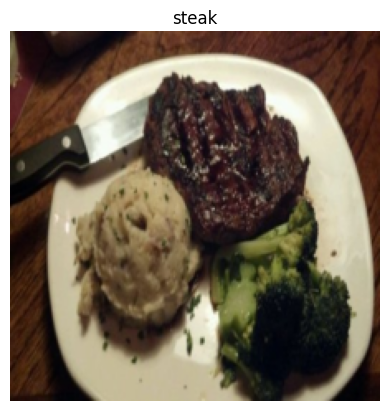

In [15]:
# Plot the image
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) # (color_channels, h,w) -> (h,w, color_channels)
plt.title(class_names[label])
plt.axis(False)

### 3. Replicating ViT: Overview

Looking at a whole ML research aper can be intimidating.

So in order to make it more understatable, we break it down into smaller pieces.

* **Inputs** - What goes into the model (in our case, image tensors (batches))
* **Outputs** - What come out of the model/layer/block ? (in our case: Classification labels)
* **Layers** - Takes an input, manipulates it with a function (e.g self-attention)
* **Block** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT overview: "gathering the pieces"

* Figure 1: Visual overview of the architecture
* 4 equations: Math equations that define the functions of each layer/block
* Table 1: different hyperparameters for the architecture/training.
* Text

#### Figure 1
<img src = "https://drive.google.com/file/d/1g03SePH4WFA6D5x5qVRX8GXJm853wM8U/open?usp=drive_link" alt = 'figure 1'/>

* Embedding = learning representation (random in the beggining and imporve over time)

#### 4 Equations
<img src='https://drive.google.com/file/d/1S7fXVm0WcGvP8znz8mv_S7aOkm9rXF0B/view?usp=drive_link' />

#### Table 1
<img src ='https://drive.google.com/file/d/1Ql-pUCKl49X2Wxo1dNjIb28OFhs-vI4z/view?usp=drive_link' />



### Table 1

There are 3 models presented in the paper:

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers.
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size -the number of hidden units/neurons in the MLP.
* Head - the number of the multi-head self-attention.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding.

Layers = input -> function -> output

What's the input shape?

What's the output shape?

### 4.1 Calculating input and output shapes.

* Input shape : (224,224,3) -> single image -> (height,width, color channels)
* Output shape: (
* Input image: $H\times{W}\times{C}$ ((height x width x color channels)
* Output image: $\mathbb{N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N =number of patches = (height * width) /p^2
* D = constant latent vector size = embedding dimension (see table 1)


In [16]:
# Create exampole values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [20]:
# Input shape
embedding_layer_input_shape = (height,width,color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape} ( number_of_patches, embedding_dimension)')


Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) ( number_of_patches, embedding_dimension)


(-0.5, 223.5, 223.5, -0.5)

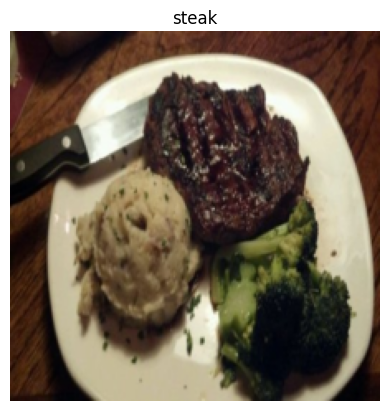

In [18]:
### 4.2 Turning a single image into patches
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [21]:
image.shape

torch.Size([3, 224, 224])

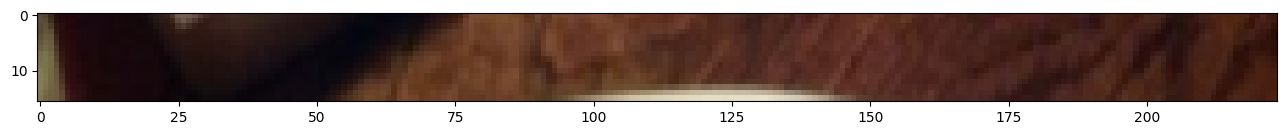

In [26]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # convert image to cc last (H,W,C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


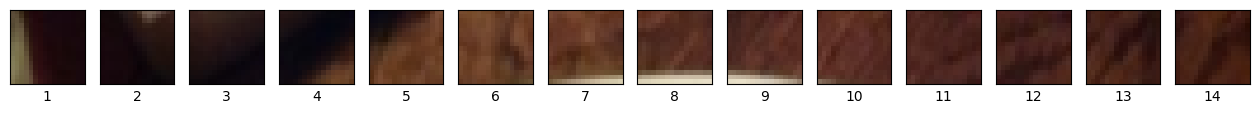

In [33]:
# Setup code to plot row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size // patch_size, # one columnn per patch
                        sharex=True,
                        sharey=True,
                        figsize = (patch_size,patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])